In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install pip install tensorflow-addons


Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.1 MB/s eta 0:00:00


In [ ]:
import keras 
import pandas as pd
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from IPython import display
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras import Input, Model,layers
from tensorflow.keras.utils import img_to_array
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from glob import glob
from functools import partial

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from PIL import Image


import gdown
from zipfile import ZipFile
# for reproducibility - ref https://machinelearningmastery.com/reproducible-results-neural-networks-keras/ and https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
np.random.seed(9)
tf.keras.utils.set_random_seed(10)

# loading data from gdrive
covid19_dataset = os.path.abspath("/content/gdrive/My Drive/COVID-19 Dataset/")

!ls "/content/gdrive/My Drive/COVID-19 Dataset/"


CT  X-ray


In [ ]:
#@markdown #**Anti-Disconnect for Google Colab**
#@markdown ## Run this to stop it from disconnecting automatically 
#@markdown  **(It will anyhow disconnect after 6 - 12 hrs for using the free version of Colab.)**
#@markdown  *(Colab Pro users will get about 24 hrs usage time)*
#@markdown ---
# taken from https://colab.research.google.com/github/justinjohn0306/VQGAN-CLIP/blob/main/VQGAN%2BCLIP_%28z%2Bquantize_method_with_augmentations%2C_user_friendly_interface%29.ipynb#scrollTo=XHyPd4oxVp_l stops colab disconnecting
import IPython
js_code = '''
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
'''
IPython.display.Javascript(js_code)


<IPython.core.display.Javascript object>

# All VAE models based off example here https://keras.io/examples/generative/vae/ and refactored

# X-ray COVID VAE


In [ ]:
# load images
image_size = (128,128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    covid19_dataset + '/X-ray/COVID/', label_mode=None, image_size=image_size, batch_size=16,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)


Found 4044 files belonging to 1 classes.


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
latent_dim = 100

encoder_inputs = keras.Input(shape=(128, 128, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)

x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 128)  73856       ['conv2d_1[0][0]']         

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      73856     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 32)       1846

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mae(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def get_vae():
      return VAE(name='ExtensiveCOVIDXrayVAE')


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(dataset, epochs=30)
encoder.save('/content/gdrive/My Drive/VAEModelsFinalMasters/Extensive/COVIDXray/COVIDVAEXrayEncoder.tf')
decoder.save('/content/gdrive/My Drive/VAEModelsFinalMasters/Extensive/COVIDXray/COVIDVAEEXrayDecorder.tf')


Epoch 1/30
253/253 [==============================] - 18s 51ms/step - loss: 2519.8777 - reconstruction_loss: 2526.6702 - kl_loss: 2.1388
Epoch 2/30
253/253 [==============================] - 14s 54ms/step - loss: 2511.6783 - reconstruction_loss: 2527.6643 - kl_loss: 2.0978
Epoch 3/30
253/253 [==============================] - 14s 54ms/step - loss: 2515.0456 - reconstruction_loss: 2524.2349 - kl_loss: 2.0882
Epoch 4/30
253/253 [==============================] - 14s 54ms/step - loss: 2509.8271 - reconstruction_loss: 2524.3640 - kl_loss: 1.9816
Epoch 5/30
253/253 [==============================] - 14s 54ms/step - loss: 2510.2277 - reconstruction_loss: 2524.7329 - kl_loss: 2.0696
Epoch 6/30
253/253 [==============================] - 14s 54ms/step - loss: 2505.2137 - reconstruction_loss: 2525.1404 - kl_loss: 1.9570
Epoch 7/30
253/253 [==============================] - 14s 54ms/step - loss: 2505.3413 - reconstruction_loss: 2525.5615 - kl_loss: 1.9902
Epoch 8/30
253/253 [=====================

1/1 [==============================] - 0s 21ms/step


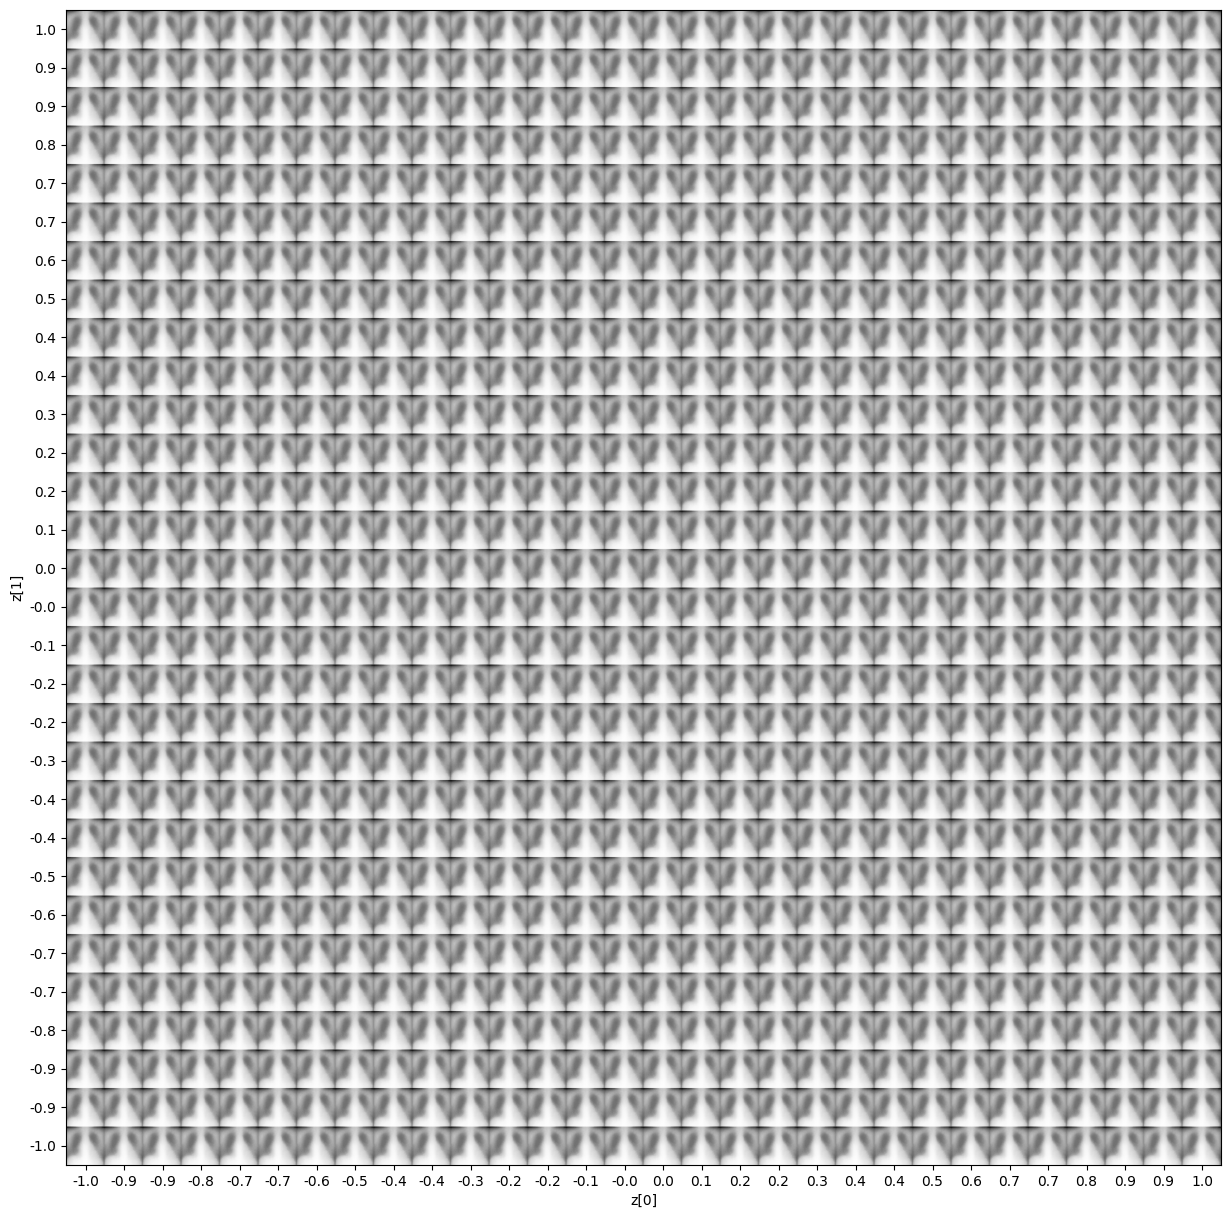

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([np.zeros(100)])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure,cmap='Greys_r')
    plt.show()


plot_latent_space(vae)
     


## CT Non COVID


In [ ]:
# load images
image_size = (128,128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    covid19_dataset + '/CT/Non-COVID/', label_mode=None, image_size=image_size, batch_size=16,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)


Found 2627 files belonging to 1 classes.


In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mae(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    def get_vae():
      return VAE(name='ExtensiveCOVIDXrayVAE')


In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(dataset, epochs=30)
encoder.save('/content/gdrive/My Drive/VAEModelsFinalMasters/Extensive/COVIDXray/NonCOVIDVAECTEncoder.tf')
decoder.save('/content/gdrive/My Drive/VAEModelsFinalMasters/Extensive/COVIDXray/NonCOVIDVAEECTDecorder.tf')


Epoch 1/30
165/165 [==============================] - 49s 234ms/step - loss: 4440.5569 - reconstruction_loss: 4311.4805 - kl_loss: 1.7099
Epoch 2/30
165/165 [==============================] - 3s 18ms/step - loss: 4158.8302 - reconstruction_loss: 4156.1982 - kl_loss: 2.9685
Epoch 3/30
165/165 [==============================] - 3s 18ms/step - loss: 4120.2021 - reconstruction_loss: 4142.5083 - kl_loss: 3.6518
Epoch 4/30
165/165 [==============================] - 3s 17ms/step - loss: 4111.2893 - reconstruction_loss: 4127.9004 - kl_loss: 3.8360
Epoch 5/30
165/165 [==============================] - 3s 17ms/step - loss: 4124.3687 - reconstruction_loss: 4133.3501 - kl_loss: 3.9853
Epoch 6/30
165/165 [==============================] - 3s 17ms/step - loss: 4118.2111 - reconstruction_loss: 4125.8901 - kl_loss: 3.9780
Epoch 7/30
165/165 [==============================] - 3s 18ms/step - loss: 4123.4854 - reconstruction_loss: 4135.3359 - kl_loss: 3.9151
Epoch 8/30
165/165 [==========================

1/1 [==============================] - 0s 22ms/step


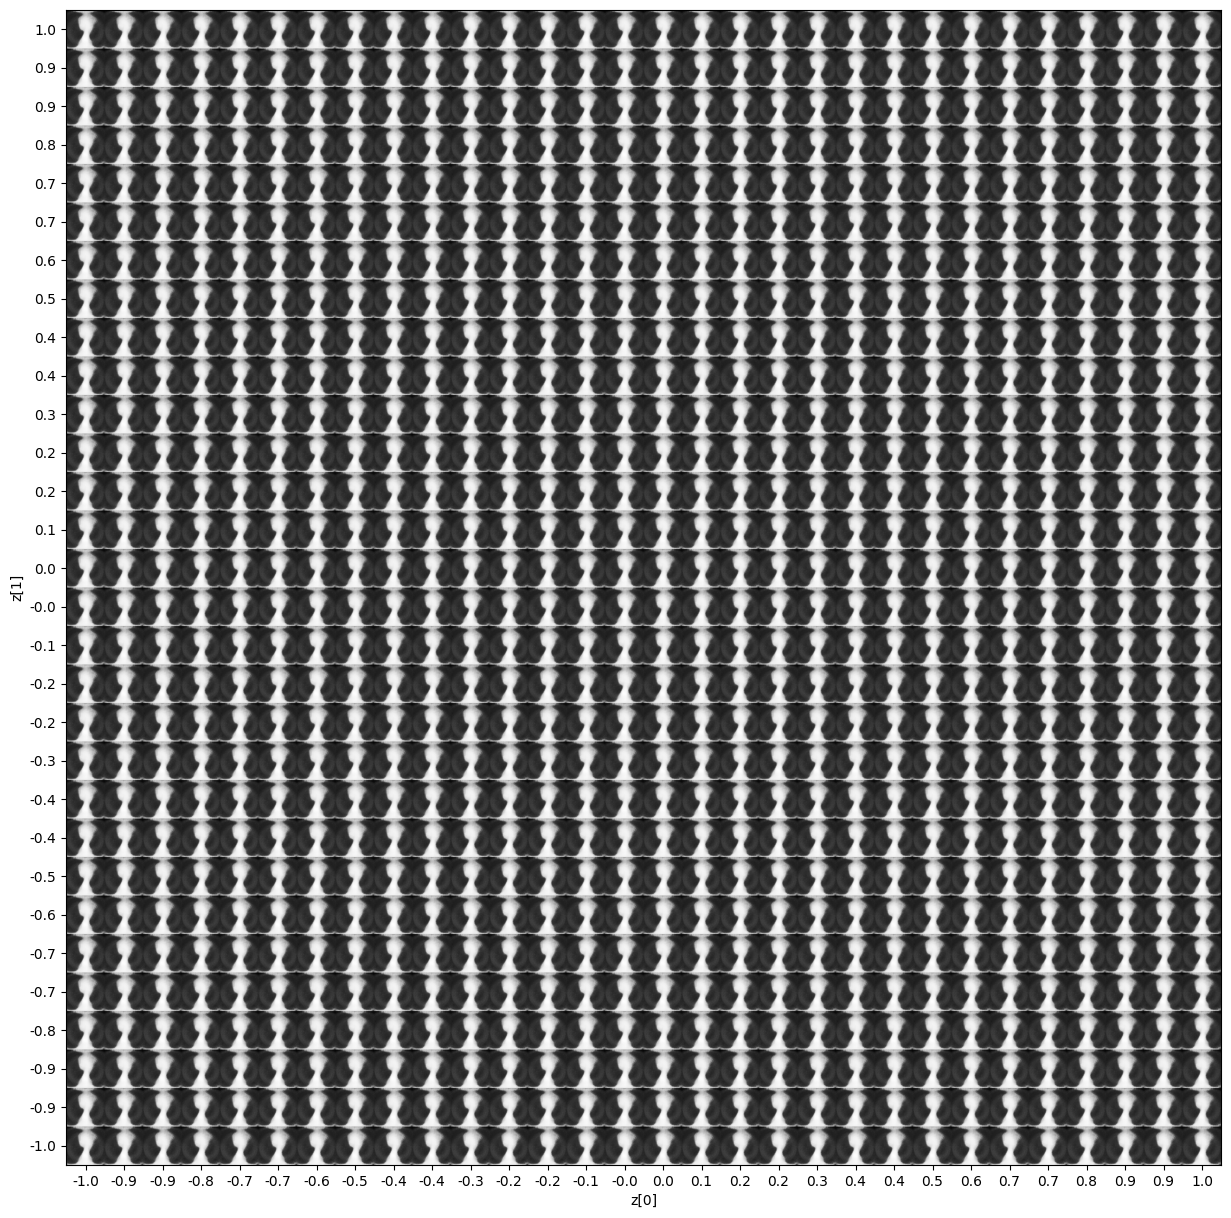

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 128
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([np.zeros(100)])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure,cmap='Greys_r')
    plt.show()


plot_latent_space(vae)
     


# All DCGAN models were based off https://keras.io/examples/generative/dcgan_overriding_train_step/ example here and refactored

# Xray COVID

In [ ]:
# load images
image_size = (128,128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    covid19_dataset + '/X-ray/COVID/', label_mode=None, image_size=image_size, batch_size=16,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)


Found 4044 files belonging to 1 classes.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
num_channels = 3
num_classes = 1
latent_dim = 256

In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

257 4


In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

# Create the generator.
generator = keras.Sequential(A
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.3),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.3),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.3),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.3),
        layers.Conv2D(3, kernel_size=4, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)           

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    def get_gan():
      return GAN(name='DC_GAN_COVID19_COVID_Xray')



In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        imageFolder = 0
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save('/content/gdrive/My Drive/COVID-19 Data Augmented COVID X-Ray' + '/' + "generated_img_%03d_%d.png" % (epoch, i))


In [ ]:
epochs = 200  # In practice, use ~100 epochs 


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


model = gan.get_gan
# Save the model
generator.save('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/Xray_COVID_Model_test_Extensive/Generator',save_format='tf')
discriminator.save('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/Xray_COVID_Model_test_Extensive/Discriminator',save_format='tf')


Epoch 1/200
253/253 [==============================] - 133s 233ms/step - d_loss: 0.5081 - g_loss: 0.6379
Epoch 2/200
253/253 [==============================] - 36s 141ms/step - d_loss: 0.4262 - g_loss: 0.8379
Epoch 3/200
253/253 [==============================] - 36s 140ms/step - d_loss: 0.3544 - g_loss: 1.1402
Epoch 4/200
253/253 [==============================] - 36s 142ms/step - d_loss: 0.4209 - g_loss: 1.2938
Epoch 5/200
253/253 [==============================] - 36s 141ms/step - d_loss: 0.9504 - g_loss: 0.6536
Epoch 6/200
253/253 [==============================] - 36s 140ms/step - d_loss: 0.7354 - g_loss: 1.0003
Epoch 7/200
253/253 [==============================] - 36s 140ms/step - d_loss: 0.6814 - g_loss: 1.0150
Epoch 8/200
253/253 [==============================] - 36s 141ms/step - d_loss: 0.6497 - g_loss: 0.9612
Epoch 9/200
253/253 [==============================] - 36s 141ms/step - d_loss: 0.6756 - g_loss: 0.7771
Epoch 10/200
253/253 [==============================] - 36s 140

# X-Ray Non covid model DCGAN based off https://keras.io/examples/generative/dcgan_overriding_train_step/ example here and refactored

In [ ]:
# load images
image_size = (128,128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    covid19_dataset + '/X-ray/Non-COVID/', label_mode=None, image_size=image_size, batch_size=16,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)


Found 5493 files belonging to 1 classes.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
num_channels = 3
num_classes = 1
latent_dim = 256

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

# Create the generator.
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(16 * 16 * 128),
        layers.Reshape((16, 16, 128)),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=4, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)           

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    def get_gan():
      return GAN(name='DC_GAN_COVID19_NON_COVID_Xray')



In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        imageFolder = 0
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save('/content/gdrive/My Drive/Data_Augmented_COVID_Xray_Non_COVID' + '/' + "generated_img_%03d_%d.png" % (epoch, i))


In [ ]:
epochs = 100  # In practice, use ~100 epochs 


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.00001,momentum=0),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.00001,momentum=0),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


model = gan.get_gan
# Save the model
generator.save('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/COVID-Data_Augmented_COVID_XrayModelNonCovid/Generator',save_format='tf')
discriminator.save('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/COVID-Data_Augmented_COVID_XrayModelNonCovid/Discriminator',save_format='tf')


Epoch 1/100
344/344 [==============================] - 41s 109ms/step - d_loss: 0.6459 - g_loss: 0.9787
Epoch 2/100
344/344 [==============================] - 38s 109ms/step - d_loss: 0.6792 - g_loss: 0.8639
Epoch 3/100
344/344 [==============================] - 38s 109ms/step - d_loss: 0.6997 - g_loss: 0.6929
Epoch 4/100
344/344 [==============================] - 38s 109ms/step - d_loss: 0.6943 - g_loss: 0.7507
Epoch 5/100
344/344 [==============================] - 38s 109ms/step - d_loss: 0.6871 - g_loss: 0.7922
Epoch 6/100
344/344 [==============================] - 38s 110ms/step - d_loss: 0.6799 - g_loss: 0.7965
Epoch 7/100
344/344 [==============================] - 38s 110ms/step - d_loss: 0.6955 - g_loss: 0.7607
Epoch 8/100
344/344 [==============================] - 38s 109ms/step - d_loss: 0.6935 - g_loss: 0.7476
Epoch 9/100
344/344 [==============================] - 38s 109ms/step - d_loss: 0.6914 - g_loss: 0.7570
Epoch 10/100
344/344 [==============================] - 38s 109m

# CT COVID DCGANs based off https://keras.io/examples/generative/dcgan_overriding_train_step/ example here and refactored

In [ ]:
# load images
image_size = (128,128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    covid19_dataset + '/CT/COVID/', label_mode=None, image_size=image_size, batch_size=64,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)


Found 5427 files belonging to 1 classes.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
num_channels = 3
num_classes = 1
latent_dim = 128

In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

129 4


In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

# Create the generator.
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=4, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)           

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    def get_gan():
      return GAN(name='DC_GAN_COVID19_COVID_CT')



In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        imageFolder = 0
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save('/content/gdrive/My Drive/COVID-19 Data Augmented COVID CT' + '/' + "generated_img_%03d_%d.png" % (epoch, i))


In [ ]:
epochs = 100  # In practice, use ~100 epochs 


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


model = gan.get_gan
# Save the model
generator.save('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/COVID-19_Augmented_COVID_CTModel/Generator',save_format='tf')
discriminator.save('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/COVID-19_Augmented_COVID_CTModel/Discriminator',save_format='tf')


Epoch 1/100
85/85 [==============================] - 44s 476ms/step - d_loss: 0.5077 - g_loss: 0.7655
Epoch 2/100
85/85 [==============================] - 35s 405ms/step - d_loss: 0.6077 - g_loss: 1.0237
Epoch 3/100
85/85 [==============================] - 35s 405ms/step - d_loss: 0.6522 - g_loss: 0.8763
Epoch 4/100
85/85 [==============================] - 35s 406ms/step - d_loss: 0.6348 - g_loss: 0.8716
Epoch 5/100
85/85 [==============================] - 35s 406ms/step - d_loss: 0.6530 - g_loss: 0.8438
Epoch 6/100
85/85 [==============================] - 35s 407ms/step - d_loss: 0.6408 - g_loss: 0.8569
Epoch 7/100
85/85 [==============================] - 35s 410ms/step - d_loss: 0.6335 - g_loss: 0.8718
Epoch 8/100
85/85 [==============================] - 35s 406ms/step - d_loss: 0.6314 - g_loss: 0.8751
Epoch 9/100
85/85 [==============================] - 35s 406ms/step - d_loss: 0.6307 - g_loss: 0.8792
Epoch 10/100
85/85 [==============================] - 35s 405ms/step - d_loss: 0.6

# CT Non COVID DCGANs based off https://keras.io/examples/generative/dcgan_overriding_train_step/ example here and refactored



In [ ]:
# load images
image_size = (128,128)
img_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    covid19_dataset + '/CT/Non-COVID/', label_mode=None, image_size=image_size, batch_size=64,crop_to_aspect_ratio=True
)

dataset = img_dataset.map(lambda x: x / 255.0)


Found 2627 files belonging to 1 classes.


In [ ]:
num_channels = 3
num_classes = 1
latent_dim = 256

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.5),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

# Create the generator.
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(4 * 4 * 128),
        layers.Reshape((4, 4, 128)),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1024, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=4, padding="same", activation="tanh"),
    ],
    name="generator",
)
generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_99 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_57 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_100 (LeakyReLU)  (None, 32, 32, 128)      0         
                                                                 
 conv2d_58 (Conv2D)          (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_101 (LeakyReLU)  (None, 16, 16, 128)      0         
                                                                 
 flatten_14 (Flatten)        (None, 32768)           

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    def get_gan():
      return GAN(name='DC_GAN_COVID19_NON_COVID_CT')



In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        imageFolder = 0
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save('/content/gdrive/My Drive/Data_Augmented_COVID_CT_Non_COVID' + '/' + "generated_img_%03d_%d.png" % (epoch, i))


In [ ]:
epochs = 100  # In practice, use ~100 epochs 


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0),
    g_optimizer=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


model = gan.get_gan
# Save the model
generator.save('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/Data_Augmented_COVID_CTModelNonCovid/Generator',save_format='tf')
discriminator.save('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/Data_Augmented_COVID_CTModelNonCovid/Discriminator',save_format='tf')


Epoch 1/100
42/42 [==============================] - 20s 398ms/step - d_loss: 0.4833 - g_loss: 0.7271
Epoch 2/100
42/42 [==============================] - 17s 396ms/step - d_loss: 0.2744 - g_loss: 1.2979
Epoch 3/100
42/42 [==============================] - 17s 397ms/step - d_loss: 0.4096 - g_loss: 2.2703
Epoch 4/100
42/42 [==============================] - 17s 398ms/step - d_loss: 0.3900 - g_loss: 2.5052
Epoch 5/100
42/42 [==============================] - 17s 399ms/step - d_loss: 0.6553 - g_loss: 1.6746
Epoch 6/100
42/42 [==============================] - 17s 399ms/step - d_loss: 0.7077 - g_loss: 1.2637
Epoch 7/100
42/42 [==============================] - 17s 400ms/step - d_loss: 0.5952 - g_loss: 1.1593
Epoch 8/100
42/42 [==============================] - 17s 399ms/step - d_loss: 0.5944 - g_loss: 1.0245
Epoch 9/100
42/42 [==============================] - 17s 399ms/step - d_loss: 0.6348 - g_loss: 0.9312
Epoch 10/100
42/42 [==============================] - 17s 400ms/step - d_loss: 0.6

## Loading Models

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }
    def get_gan():
      return GAN(name='DC_GAN_COVID19_COVID_Xray')



In [ ]:
# need to generate 1k COVID images
generator = keras.models.load_model('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/COVID-19_Augmented_COVID_XRayModel/Generator')
discriminator = keras.models.load_model('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/COVID-19_Augmented_COVID_XRayModel/Discriminator/')
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=256)
gan.compile(
    discriminator,
    generator,
    loss_fn=keras.losses.BinaryCrossentropy(),
)
generated_batch = 0
generator.summary
for i in range(100):
  random_latent_vectors = tf.random.normal(shape=(10, 256))
  generated_images = gan.generator(random_latent_vectors)
  generated_images *= 255
  generated_images.numpy()
  imageFolder = 0
  for j in range(10):
    img = tf.keras.preprocessing.image.array_to_img(generated_images[j])
    img.save('/content/gdrive/My Drive/COVIDXrayAugmentedDCGANExtensiveFinal' + '/' + "generated_img_%03d_%d.png" % (generated_batch,j))
  generated_batch += 1


In [ ]:
# meed 2270 images of CT Non COVID
generator = keras.models.load_model('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/Data_Augmented_COVID_CTModelNonCovid/Generator')
discriminator = keras.models.load_model('/content/gdrive/My Drive/GANModelsFinalMasters/DCGANS/Data_Augmented_COVID_CTModelNonCovid/Discriminator/')
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=256)
gan.compile(
    discriminator,
    generator,
    loss_fn=keras.losses.BinaryCrossentropy(),
)
generated_batch = 0
generator.summary
for i in range(270):
  random_latent_vectors = tf.random.normal(shape=(10, 256))
  generated_images = gan.generator(random_latent_vectors)
  generated_images *= 255
  generated_images.numpy()
  imageFolder = 0
  for j in range(10):
    img = tf.keras.preprocessing.image.array_to_img(generated_images[j])
    img.save('/content/gdrive/My Drive/NonCOVIDCTAugmentedDCGANExtensiveFinal' + '/' + "generated_img_%03d_%d.png" % (generated_batch,j))
  generated_batch += 1
